In [1]:
# Cell 1 — Data loading and preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# ===============================
# 1. 数据读取与基础预处理
# ===============================

df = pd.read_csv("index.csv")

# 创建 Date 索引
df.insert(0, "Date", pd.to_datetime(df[["Year", "Month", "Day"]]))
df.set_index(["Date"], inplace=True)
df.drop(columns=["Year", "Month", "Day"], inplace=True)

# 去掉不用的列（联邦基金目标区间）
drop_cols = [
    "Federal Funds Target Rate",
    "Federal Funds Upper Target",
    "Federal Funds Lower Target",
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 目标：Real GDP (Percent Change)
targ_df = pd.DataFrame(df["Real GDP (Percent Change)"])

# 找到通胀开始记录的时间（仅打印一次，方便检查数据）
for i, j in enumerate(df["Inflation Rate"]):
    if not np.isnan(j):
        print(f"Inflation rates begin: {df.index[i]}")
        break

# 去掉没有通胀记录的行 & 没有目标值的末尾
df = df.drop(df.loc["1954-07-01":"1958-01-01"].index, errors="ignore")
df = df.drop(df.loc["2016-11-01":].index, errors="ignore")
targ_df = targ_df.drop(targ_df.loc["1954-07-01":"1958-01-01"].index, errors="ignore")
targ_df = targ_df.drop(targ_df.loc["2016-11-01":].index, errors="ignore")

# 去掉非月初记录（中旬调整）
idx_mm = [i for i, d in enumerate(df.index.day) if d != 1]
df = df.drop(df.iloc[idx_mm].index)
idx_mm = [i for i, d in enumerate(targ_df.index.day) if d != 1]
targ_df = targ_df.drop(targ_df.iloc[idx_mm].index)

# ===============================
# 2. TimeSeriesSplit 做 train / test 划分（最后一折）
# ===============================

tss_outer = TimeSeriesSplit(n_splits=2)
train_index, test_index = list(tss_outer.split(df, targ_df))[-1]

X_train = df.iloc[train_index, :].copy()
X_test  = df.iloc[test_index, :].copy()
y_train = targ_df.iloc[train_index].copy()
y_test  = targ_df.iloc[test_index].copy()

# X 中去掉目标列
X_train = X_train.drop(columns=["Real GDP (Percent Change)"])
X_test  = X_test.drop(columns=["Real GDP (Percent Change)"])

# ===============================
# 3. 构造滞后特征（利率 / 通胀 / 失业率）
# ===============================

lags = [1, 2, 3, 4, 5]
base_cols = ["Effective Federal Funds Rate", "Inflation Rate", "Unemployment Rate"]

for col in base_cols:
    for L in lags:
        X_train[f"{col} lag{L}"] = X_train[col].shift(L)
        X_test[f"{col} lag{L}"] = X_test[col].shift(L)

# 去掉前 5 行（lag1~5 需要历史）
X_train = X_train.iloc[5:].copy()
X_test  = X_test.iloc[5:].copy()
y_train = y_train.loc[X_train.index]
y_test  = y_test.loc[X_test.index]

# ===============================
# 4. 限制为季度数据 + 对齐索引
# ===============================

y_train = y_train.loc["1958-08-01":"1997-03-01"].dropna()
X_train = X_train.loc[y_train.index]
print(f"Check indices (train): {sum(y_train.index != X_train.index)}")

y_test = y_test.loc["1997-10-01":"2016-10-01"].dropna()
X_test = X_test.loc[y_test.index]
print(f"Check indices (test): {sum(y_test.index != X_test.index)}")

# ===============================
# 5. 构造 GDP 的滞后（lag1~3）
# ===============================

gdp_lags = [1, 2, 3]
for L in gdp_lags:
    X_train[f"Real GDP (Percent Change) lag{L}"] = y_train["Real GDP (Percent Change)"].shift(L)
    X_test[f"Real GDP (Percent Change) lag{L}"] = y_test["Real GDP (Percent Change)"].shift(L)

# 按 GDP lag 去掉前 3 行
X_train = X_train.iloc[3:].copy()
X_test  = X_test.iloc[3:].copy()
y_train = y_train.loc[X_train.index]
y_test  = y_test.loc[X_test.index]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# 为后续模型保留“完整特征版”
X_train_full = X_train.copy()
X_test_full  = X_test.copy()

# ===============================
# 6. 基于相关系数的特征筛选（可选：用于缓解高维问题）
# ===============================

corr_with_target = X_train_full.corrwith(y_train["Real GDP (Percent Change)"])
corr_abs = corr_with_target.abs().sort_values(ascending=False)
print("\nTop correlations (absolute):")
print(corr_abs.head(10))

corr_threshold = 0.20  # 你可以在模型 cell 再改这个阈值
selected_features = corr_abs[corr_abs >= corr_threshold].index.tolist()

# 确保 GDP lag 一定保留
gdp_lag_cols = [c for c in X_train_full.columns if c.startswith("Real GDP (Percent Change) lag")]
for c in gdp_lag_cols:
    if c not in selected_features:
        selected_features.append(c)

selected_features = list(dict.fromkeys(selected_features))  # 去重

print(f"\nSelected features (num={len(selected_features)}):")
print(selected_features)

X_train_fs = X_train_full[selected_features].copy()
X_test_fs  = X_test_full[selected_features].copy()

print("X_train_full shape:", X_train_full.shape)
print("X_train_fs shape:", X_train_fs.shape)


Inflation rates begin: 1958-01-01 00:00:00
Check indices (train): 0
Check indices (test): 0
X_train shape: (151, 21)
X_test shape: (74, 21)

Top correlations (absolute):
Effective Federal Funds Rate lag4    0.413944
Effective Federal Funds Rate lag5    0.402652
Effective Federal Funds Rate lag3    0.399229
Effective Federal Funds Rate lag2    0.362330
Effective Federal Funds Rate lag1    0.331153
Inflation Rate                       0.330946
Inflation Rate lag1                  0.328236
Inflation Rate lag2                  0.326547
Effective Federal Funds Rate         0.317204
Inflation Rate lag3                  0.307583
dtype: float64

Selected features (num=15):
['Effective Federal Funds Rate lag4', 'Effective Federal Funds Rate lag5', 'Effective Federal Funds Rate lag3', 'Effective Federal Funds Rate lag2', 'Effective Federal Funds Rate lag1', 'Inflation Rate', 'Inflation Rate lag1', 'Inflation Rate lag2', 'Effective Federal Funds Rate', 'Inflation Rate lag3', 'Inflation Rate lag4'

In [2]:
# Cell 2 — Helper functions for model training, evaluation and learning curves

from sklearn.model_selection import GridSearchCV, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

results = []  # 用于收集不同方法的 R² 结果

def run_model_pipeline(label, reg_pipe, param_grid, 
                       X_train, X_test, y_train, y_test,
                       cv_splits=5, plot_learning=True, random_state=42):
    """
    通用模型评估函数：
    - TimeSeriesSplit 做交叉验证
    - GridSearchCV 调参（如果 param_grid 不为空）
    - 打印 CV R² 和 Test R²
    - 绘制 learning curve（R²）
    - 将结果存入全局 results 列表
    """
    from sklearn.model_selection import TimeSeriesSplit

    print(f"\n===== {label} =====")
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    if param_grid is not None and len(param_grid) > 0:
        grid = GridSearchCV(
            reg_pipe,
            param_grid=param_grid,
            cv=tscv,
            scoring="r2",
            n_jobs=-1
        )
        grid.fit(X_train, y_train.values.ravel())
        best_pipe = grid.best_estimator_
        print("Best params:", grid.best_params_)
        print(f"Best CV R² (GridSearchCV): {grid.best_score_:.3f}")
    else:
        best_pipe = reg_pipe
        best_pipe.fit(X_train, y_train.values.ravel())

    # 用 best_pipe 再做一次 cross_validate，拿到 train / val R²
    cv_reg = cross_validate(
        best_pipe, X_train, y_train,
        cv=tscv, n_jobs=-1,
        scoring=("r2",),
        return_train_score=True
    )
    cv_train_r2 = cv_reg["train_r2"].mean()
    cv_val_r2 = cv_reg["test_r2"].mean()

    print(f"CV Mean R2 (train): {cv_train_r2:.3f} ± {cv_reg['train_r2'].std():.3f}")
    print(f"CV Mean R2 (val):   {cv_val_r2:.3f} ± {cv_reg['test_r2'].std():.3f}")

    # 测试集 R²
    y_pred = pd.Series(best_pipe.predict(X_test), index=y_test.index)
    test_r2 = r2_score(y_test, y_pred)
    print(f"Test R2: {test_r2:.3f}")

    # Learning curve（R²）
    if plot_learning:
        train_sizes = np.linspace(0.2, 1.0, 5)
        train_sizes, train_scores, val_scores = learning_curve(
            best_pipe, X_train, y_train,
            cv=tscv, scoring="r2", n_jobs=-1,
            train_sizes=train_sizes
        )
        plt.figure(figsize=(7, 5))
        plt.title(f"Learning Curve — {label}")
        plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R²")
        plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R²")
        plt.xlabel("Training samples")
        plt.ylabel("R²")
        plt.grid(True)
        plt.legend()
        plt.show()

    # 保存结果
    results.append({
        "label": label,
        "cv_train_r2": cv_train_r2,
        "cv_val_r2": cv_val_r2,
        "test_r2": test_r2
    })

    return best_pipe, y_pred



===== Baseline KNN (all features) =====
Best params: {'model__n_neighbors': 15, 'model__p': 2, 'model__weights': 'uniform'}
Best CV R² (GridSearchCV): -0.209
CV Mean R2 (train): 0.165 ± 0.089
CV Mean R2 (val):   -0.209 ± 0.533
Test R2: -0.909


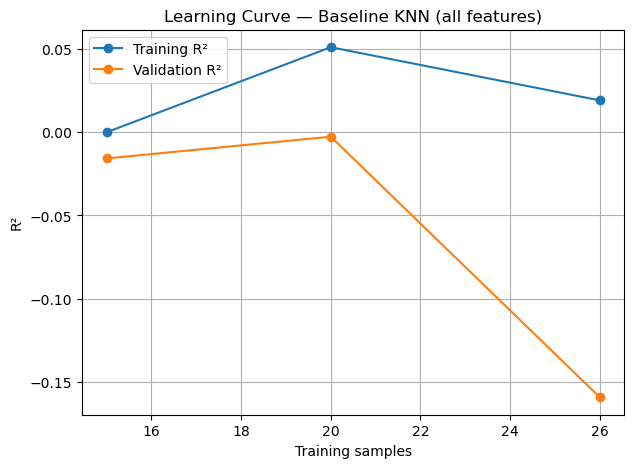

In [3]:
# Cell 3 — Baseline KNN (all features)

from sklearn.neighbors import KNeighborsRegressor

RNG = 42

knn_full_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor())
])

param_grid_knn_full = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],  # Manhattan & Euclidean
}

knn_full_model, y_pred_knn_full = run_model_pipeline(
    label="Baseline KNN (all features)",
    reg_pipe=knn_full_pipe,
    param_grid=param_grid_knn_full,
    X_train=X_train_full,
    X_test=X_test_full,
    y_train=y_train,
    y_test=y_test,
    cv_splits=5,
    plot_learning=True,
    random_state=RNG
)



===== KNN (feature-selected) =====


C:\Users\18249\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-0.18723264 -0.16193808 -0.17430026 -0.13997496 -0.19081538 -0.15438966
 -0.13853622 -0.10177319 -0.1673496  -0.12467994 -0.16091992 -0.12295153
         nan         nan]
  warnings.warn(


Best params: {'model__n_neighbors': 17, 'model__p': 2, 'model__weights': 'distance'}
Best CV R² (GridSearchCV): -0.102
CV Mean R2 (train): 1.000 ± 0.000
CV Mean R2 (val):   -0.102 ± 0.212
Test R2: -0.888


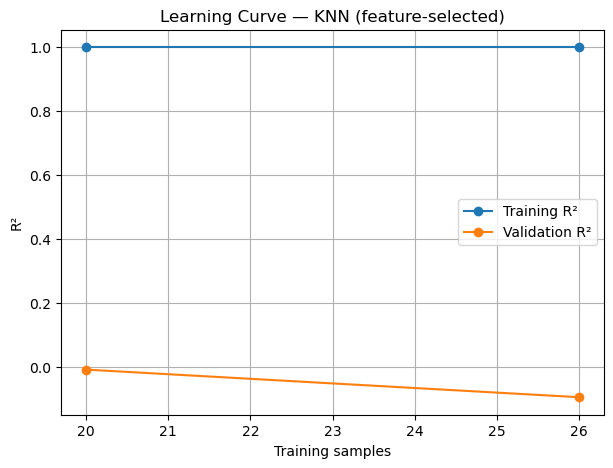

In [4]:
# Cell 4 — KNN with feature selection (reduced feature space)

knn_fs_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor())
])

param_grid_knn_fs = {
    "model__n_neighbors": [5, 9, 13, 17, 21, 25, 31],
    "model__weights": ["uniform", "distance"],
    "model__p": [2],  # 只用 Euclidean 距离
}

knn_fs_model, y_pred_knn_fs = run_model_pipeline(
    label="KNN (feature-selected)",
    reg_pipe=knn_fs_pipe,
    param_grid=param_grid_knn_fs,
    X_train=X_train_fs,
    X_test=X_test_fs,
    y_train=y_train,
    y_test=y_test,
    cv_splits=5,
    plot_learning=True,
    random_state=RNG
)



===== Bagging KNN (feature-selected) =====
Best params: {'model__estimator__n_neighbors': 15, 'model__estimator__p': 2, 'model__estimator__weights': 'distance', 'model__n_estimators': 20}
Best CV R² (GridSearchCV): -0.123
CV Mean R2 (train): 0.865 ± 0.009
CV Mean R2 (val):   -0.123 ± 0.225
Test R2: -0.853


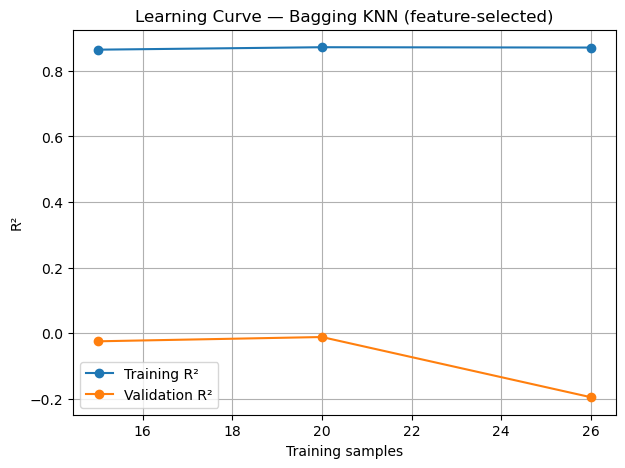

In [6]:
# Cell 5 — Bagging over KNN (variance reduction)

from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

bag_knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", BaggingRegressor(
        estimator=KNeighborsRegressor(),   # 新版 sklearn 用 estimator
        random_state=RNG
    ))
])

param_grid_bag_knn = {
    "model__n_estimators": [20, 50, 100],
    # 注意这里也要改成 estimator，而不是 base_estimator
    "model__estimator__n_neighbors": [5, 9, 15],
    "model__estimator__weights": ["uniform", "distance"],
    "model__estimator__p": [2],  # Euclidean
}

bag_knn_model, y_pred_bag_knn = run_model_pipeline(
    label="Bagging KNN (feature-selected)",
    reg_pipe=bag_knn_pipe,
    param_grid=param_grid_bag_knn,
    X_train=X_train_fs,
    X_test=X_test_fs,
    y_train=y_train,
    y_test=y_test,
    cv_splits=5,
    plot_learning=True,
    random_state=RNG
)


All methods R² summary:
                            label  cv_val_r2   test_r2
0     Baseline KNN (all features)  -0.209301 -0.909006
1          KNN (feature-selected)  -0.101773 -0.888468
2  Bagging KNN (feature-selected)  -0.123123 -0.852801

R² changes relative to baseline (Test R²):
                            label   test_r2  test_r2_change_abs  \
0     Baseline KNN (all features) -0.909006            0.000000   
1          KNN (feature-selected) -0.888468            0.020538   
2  Bagging KNN (feature-selected) -0.852801            0.056206   

   test_r2_change_pct  
0            0.000000  
1            2.259404  
2            6.183188  


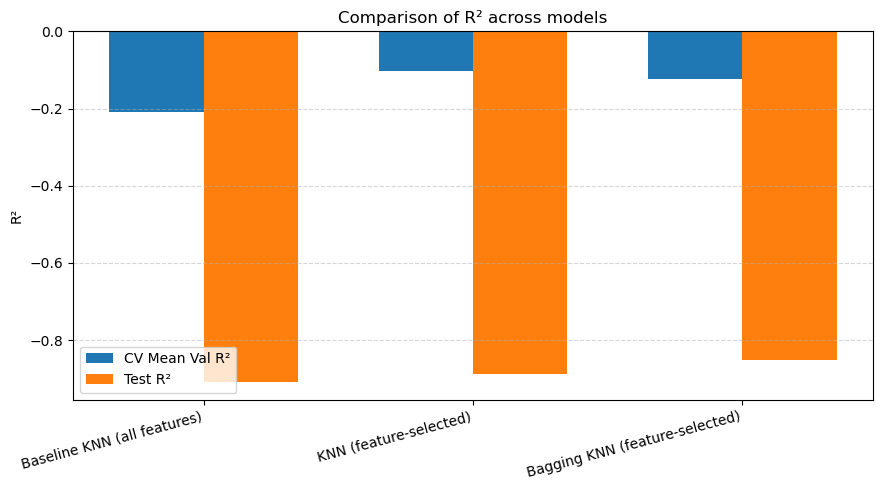

In [7]:
# Cell 7 — R² comparison and relative improvements

import pandas as pd

metrics_df = pd.DataFrame(results)
print("All methods R² summary:")
print(metrics_df[["label", "cv_val_r2", "test_r2"]])

# 以第一个方法（Baseline KNN）为基准，计算 Test R² 相对变化
if not metrics_df.empty:
    base_test_r2 = metrics_df["test_r2"].iloc[0]
    metrics_df["test_r2_change_abs"] = metrics_df["test_r2"] - base_test_r2
    if base_test_r2 != 0:
        metrics_df["test_r2_change_pct"] = (metrics_df["test_r2"] - base_test_r2) / abs(base_test_r2) * 100
    else:
        metrics_df["test_r2_change_pct"] = np.nan

    print("\nR² changes relative to baseline (Test R²):")
    print(metrics_df[["label", "test_r2", "test_r2_change_abs", "test_r2_change_pct"]])

    # 绘制每种方法的 CV Val R² 和 Test R² 柱状图
    x = np.arange(len(metrics_df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(x - width/2, metrics_df["cv_val_r2"], width, label="CV Mean Val R²")
    ax.bar(x + width/2, metrics_df["test_r2"], width, label="Test R²")

    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df["label"], rotation=15, ha="right")
    ax.set_ylabel("R²")
    ax.set_title("Comparison of R² across models")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()
